# Accessing Neuropixels Visual Coding Data

## Tutorial overview

This Jupyter notebook covers the various methods for accessing the Allen Institute Neuropixels Visual Coding dataset. We will go over how to request data, where it's stored, and what the various files contain.  If you're having trouble downloading the data, or you just want to know more about what's going on under the hood, this is a good place to start.

Currently, we do not have a web interface for browsing through the available cells and experiments, as with the [two-photon imaging Visual Coding dataset](http://observatory.brain-map.org/visualcoding). Instead, the data must be retrieved through the AllenSDK (Python 3.6+), or via requests sent to [api.brain-map.org](http://mouse.brain-map.org/static/api).

Functions related to data analysis will be covered in other tutorials. For a full list of available tutorials, see the [SDK documentation](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html).

## Options for data access

The **`EcephysProjectCache` object of the AllenSDK** is the easiest way to interact with the data. This object abstracts away the details of on-disk file storage, and delivers the data to you as ready-to-analyze Python objects. The cache will automatically keep track of which files are stored locally, and will download additional files on an as-needed basis. Usually you won't need to worry about how these files are structured, but this tutorial will cover those details in case you want to analyze them without using the AllenSDK (e.g., in Matlab). This tutorial begins with <a href='#Using-the-AllenSDK-to-retrieve-data'>an introduction to this approach</a>.

If you have an **Amazon Web Services (AWS)** account, you can use an `EcephysProjectCache` object to access the data via the Allen Brain Observatory Simple Storage Service (S3) bucket. This is an AWS Public Dataset located at `arn:aws:s3:::allen-brain-observatory` in region `us-west-2`. Launching a Jupyter notebook instance on AWS will allow you to access the complete dataset without having to download anything locally. This includes around 80 TB of raw data files, which are not accessible via the AllenSDK. The only drawback is that you'll need to pay for the time that your instance is running—but this can still be economical in many cases. A brief overview of this approach can be found <a href='#Accessing-data-on-AWS'>below</a>.

A third option is to directly download the data via **api.brain-map.org**. This should be used only as a last resort if the other options are broken or are not available to you. Instructions for this can be found <a href='#Direct-download-via-api.brain-map.org'>at the end of this tutorial</a>.

## Using the AllenSDK to retrieve data

Most users will want to access data via the AllenSDK. This requires nothing more than a Python interpreter and some free disk space to store the data locally.

How much data is there? If you want to download the complete dataset (58 experiments), you'll need 855 GB of space, split across the following files:

1. CSV files containing information about sessions, probes, channels and units (58.1 MB)
2. NWB files containing spike times, behavior data, and stimulus information for each session (146.5 GB total, min file size = 1.7 GB, max file size = 3.3 GB)
3. NWB files containing LFP data for each probe (707 GB total, min file size = 0.9 GB, max file size = 2.7 GB)

Before downloading the data, you must decide where the `manifest.json` file lives. This file serves as the map that guides the `EcephysProjectCache` object to the file locations.

When you initialize a local cache for the first time, it will create the manifest file at the path that you specify. This file lives in the same directory as the rest of the data, so make sure you put it somewhere that has enough space available. 

When you need to access the data in subsequent analysis sessions, you should point the `EcephysProjectCache` object to an _existing_ `manifest.json` file; otherwise, it will try to re-download the data in a new location.

To get started with this approach, first take care of the necessary imports:

In [2]:
import os
import shutil

import numpy as np
import pandas as pd

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

Next, we'll specify the location of the manifest file. If you're creating a cache for the first time, this file won't exist yet, but it _must_ be placed in an existing data directory. Remember to choose a location that has plenty of free space available.

In [3]:
data_directory = './ecephys_cache' # must be updated to a valid directory in your filesystem

manifest_path = os.path.join(data_directory, "manifest.json")

Now we can create the cache object, specifying both the local storage directory (the `manifest_path`) and the remote storage location (the Allen Institute data warehouse).

In [4]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

This will prepare the cache to download four files:

1. `sessions.csv` (7.8 kB)
2. `probes.csv` (27.0 kB)
3. `channels.csv` (6.6 MB)
4. `units.csv` (51.4 MB)

Each one contains a table of information related to its file name. If you're using the AllenSDK, you won't have to worry about how these files are formatted. Instead, you'll load the relevant data using specific accessor functions: `get_session_table()`, `get_probes()`, `get_channels()`, and `get_units()`. These functions return a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html?highlight=dataframe) containing a row for each item and a column for each metric.

If you are analyzing data without using the AllenSDK, you can load the data using your CSV file reader of choice. However, please be aware the columns in the original file do not necessarily match what's returned by the AllenSDK, which may combine information from multiple files to produce the final DataFrame.

Let's take a closer look at what's in the `sessions.csv` file:

In [5]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))


sessions.head()

Total number of sessions: 58


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


The `sessions` DataFrame provides a high-level overview of the Neuropixels Visual Coding dataset. The index column is a unique ID, which serves as a key for accessing the physiology data for each session. The other columns contain information about:

- the session type (i.e., which stimulus set was shown?)
- the age, sex, and genotype of the mouse (in this dataset, there's only one session per mouse)
- the number of probes, channels, and units for each session
- the brain structures recorded (CCFv3 acronyms)

If we want to find all of recordings from male Sst-Cre mice that viewed the Brain Observatory 1.1 stimulus and contain units from area LM, we can use the following query:

In [7]:
filtered_sessions = sessions[(sessions.full_genotype.str.find('Sst') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISp' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]

print(len(filtered_sessions))
filtered_sessions.head()

6


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."
758798717,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,593,1486,4,"[MGv, MGd, TH, DG, CA1, VISal, nan, SGN, LP, S..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"


The `filtered_sessions` table contains the three sessions that meet these criteria.

The code above uses standard syntax for filtering pandas DataFrames. If this is unfamiliar to you, we strongly recommend reading through the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/). The AllenSDK makes heavy use of pandas objects, so we don't have to come up with our own functions for working with tabular data.

Let's take a look at another DataFrame, extracted from the `probes.csv` file.

In [16]:
probes = cache.get_probes()

print('Total number of probes: ' + str(len(probes)))

probes.head()

Total number of probes: 332


,ecephys_session_id,lfp_sampling_rate,name,phase,sampling_rate,has_lfp_data,unit_count,channel_count,ecephys_structure_acronyms
id,,,,,,,,,
729445648,719161530,1249.998642,probeA,3a,29999.967418,True,87,374,"[APN, LP, MB, DG, CA1, VISam, nan]"
729445650,719161530,1249.996620,probeB,3a,29999.918880,True,202,368,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan]"
729445652,719161530,1249.999897,probeC,3a,29999.997521,True,207,373,"[APN, NOT, MB, DG, SUB, VISp, nan]"
729445654,719161530,1249.996707,probeD,3a,29999.920963,True,93,358,"[grey, VL, CA3, CA2, CA1, VISl, nan]"
729445656,719161530,1249.999979,probeE,3a,29999.999500,True,138,370,"[PO, VPM, TH, LP, LGd, CA3, DG, CA1, VISal, nan]"


The `probes` DataFrame contains information about the Neuropixels probes used across all recordings. Each row represents one probe from one recording session, even though the physical probes may have been used in multiple sessions. Some of the important columns are:

- `ecephys_session_id`: the index column of the `sessions` table
- `sampling_rate`: the sampling rate (in Hz) for this probe's spike band; note that each probe has a unique sampling rate around 30 kHz. The small variations in sampling rate across probes can add up to large offsets over time, so it's critical to take these differences into account. However, all of the data you will interact with has been pre-aligned to a common clock, so this value is included only for reference purposes.
- `lfp_sampling_rate`: the sampling rate (in Hz) for this probe's LFP band NWB files, after 2x downsampling from the original rate of 2.5 kHz
- `name`: the probe name is assigned based on the location of the probe on the recording rig. This is useful to keep in mind because probes with the same name are always targeted to the same cortical region and enter the brain from the same angle (`probeA` = AM, `probeB` = PM, `probeC` = V1, `probeD` = LM, `probeE` = AL, `probeF` = RL). However, the targeting is not always accurate, so the actual recorded region may be different.
- `phase`: the data may have been generated by one of two "phases" of Neuropixels probes. **3a** = prototype version; **PXI** = publicly available version ("Neuropixels 1.0"). The two phases should be equivalent from the perspective of data analysis, but there may be differences in the noise characteristics between the two acquisition systems.
- `channel_count`: the number of channels with spikes or LFP data (maximum = 384)

The `channels.csv` file contains information about each of these channels.

In [17]:
channels = cache.get_channels()

print('Total number of channels: ' + str(len(channels)))

channels.head()

Total number of channels: 123224


,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,phase,sampling_rate,has_lfp_data,unit_count
id,,,,,,,,,,,,,,,
849705558,792645504,1,11,20,8165.0,3314.0,6862.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705560,792645504,2,59,40,8162.0,3307.0,6866.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705562,792645504,3,27,40,8160.0,3301.0,6871.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705564,792645504,4,43,60,8157.0,3295.0,6875.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0
849705566,792645504,5,11,60,8155.0,3288.0,6879.0,215.0,APN,779839471,1250.001479,3a,30000.035489,True,0


The most important columns in the `channels` DataFrame concern each channel's location in physical space. Each channel is associated with a location along the probe shank (`probe_horizontal_position` and `probe_vertical_position`), and may be linked to a coordinate in the Allen Common Coordinate framework (if CCF registration is available for that probe).

The information about channel location will be merged into the `units` DataFrame, which is loaded from `units.csv`:

In [18]:
units = cache.get_units()

print('Total number of units: ' + str(len(units)))

Total number of units: 40010


This DataFrame contains metadata about the available units across all sessions. By default, the AllenSDK applies some filters to this table and only returns units above a particular quality threshold.

The default filter values are as follows:

- `isi_violations` < 0.5
- `amplitude_cutoff` < 0.1
- `presence_ratio` > 0.9

For more information about these quality metrics and how to interpret them, please refer to [this tutorial](./ecephys_quality_metrics.ipynb).

If you want to see _all_ of the available units, it's straightfoward to disable the quality metrics filters when retrieving this table: 

In [14]:
session_id = 715093703
session = cache.get_session_data(session_id)

Downloading:   0%|          | 0.00/2.86G [00:00<?, ?B/s]

In [36]:
stim_idx = 9
stim = session.get_stimulus_epochs().loc[stim_idx]
stim

start_time                  2835.86
stop_time                   3136.11
duration                    300.251
stimulus_name     natural_movie_one
stimulus_block                    4
Name: 9, dtype: object

In [24]:
session.presentationwise_spike_counts?

In [57]:
unit_ids = units.ecephys_structure_acronym == "VISp"
print(unit_ids)
bin_edges = np.linspace(0, stim["duration"], 20)
counts = session.presentationwise_spike_counts(bin_edges=bin_edges,
                                               stimulus_presentation_ids=[stim_idx],
                                               unit_ids=unit_ids)

id
915956282    False
915956340    False
915956345    False
915956349    False
915956356    False
             ...  
951911942    False
951911948    False
951911955    False
951911961    False
951912003    False
Name: ecephys_structure_acronym, Length: 40010, dtype: bool


In [58]:
counts

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 1, time_relative_to_stimulus_onset: 19, unit_id: 60)>
array([[[  0,  54, 165, ..., 252,   1,   5],
        [  0,  71, 140, ..., 211,   0,   7],
        [  0, 103, 132, ..., 185,   0,   4],
        ...,
        [  0,  62, 118, ..., 254,   0,   8],
        [  0, 112, 143, ..., 237,   0,   9],
        [  0, 121, 148, ..., 246,   0,   2]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 9
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 7.901 ... 292.3
  * unit_id                          (unit_id) int64 950930145 ... 950933960

In [61]:
plt.bar?

<BarContainer object of 19 artists>

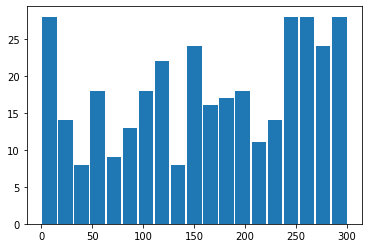

In [67]:
import matplotlib.pyplot as plt
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
bin_width = bin_edges[1] - bin_edges[0]
plt.bar(bin_centers, counts[0, :, 11], width=0.9*bin_width)

In [10]:
analysis_metrics1 = cache.get_unit_analysis_metrics_by_session_type('brain_observatory_1.1')

analysis_metrics2 = cache.get_unit_analysis_metrics_by_session_type('functional_connectivity')

print(str(len(analysis_metrics1)) + ' units in table 1')
print(str(len(analysis_metrics2)) + ' units in table 2')

21842 units in table 1
18168 units in table 2


This will download two additional files, `brain_observatory_1.1_analysis_metrics.csv` and `functional_connectivity_analysis_metrics.csv`, and load them as pandas DataFrames. Note that the total length of these DataFrames is around 40k units, because the default quality metric thresholds have been applied.

To load _all_ of the available units, and create one giant table of metrics, you can use the following code:

In [11]:
analysis_metrics1 = cache.get_unit_analysis_metrics_by_session_type('brain_observatory_1.1', amplitude_cutoff_maximum = np.inf,
                                                          presence_ratio_minimum = -np.inf,
                                                          isi_violations_maximum = np.inf)

analysis_metrics2 = cache.get_unit_analysis_metrics_by_session_type('functional_connectivity', amplitude_cutoff_maximum = np.inf,
                                                          presence_ratio_minimum = -np.inf,
                                                          isi_violations_maximum = np.inf)

all_metrics = pd.concat([analysis_metrics1, analysis_metrics2], sort=False)

print(str(len(all_metrics)) + ' units overall')

99180 units overall


The length of this DataFrame should match that of the `units` DataFrame we retrieved earlier. A few things to note about this DataFrame:

- The unit analysis metrics DataFrame _also_ includes all quality metrics, so it's a superset of the `units` DataFrame
- Since some of the stimuli in the `brain_observatory_1.1` session are not present in the `functional_connectivity` session, many of the data points in the unit analysis metrics DataFrame will be filled with `nan` values

### Accessing data for individual sessions

Assuming you've found a session you're interested in analyzing in more detail, it's now time to download the data. This is as simple as calling `cache.get_session_data()`, with the `session_id` as input. This method will check the cache for an existing NWB file and, if it's not present, will automatically download it for you.

Each NWB file can be upwards of 2 GB, so please be patient while it's downloading!

As an example, let's look at one of the sessions we selected earlier, disabling the default unit quality metrics filters:

In [12]:
session = cache.get_session_data(filtered_sessions.index.values[0],
                                 isi_violations_maximum = np.inf,
                                 amplitude_cutoff_maximum = np.inf,
                                 presence_ratio_minimum = -np.inf
                                )

print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])

['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presentations', 'structure_acronyms', 'structurewise_unit_counts', 'units']


As you can see, the `session` object has a lot of attributes and methods that can be used to access the underlying data in the NWB file. Most of these will be touched on in other tutorials, but for now we will look at the only one that is capable of triggering additional data downloads, `get_lfp()`.

In general, each NWB file is meant to be a self-contained repository of data for one recording session. However, for the Neuropixels data, we've broken with convention a bit in order to store LFP data in separate files. If we hadn't done this, analyzing one session would require an initial 15 GB file download. Now, the session is broken up in to ~2 GB chunks..

Once you have created a `session` object, downloading the LFP data is simple (but may be slow):

In [13]:
probe_id = session.probes.index.values[0]

lfp = session.get_lfp(probe_id)

Tips for analyzing LFP data can be found in [this tutorial](./ecephys_lfp_analysis.ipynb).

### Downloading the complete dataset

Analyzing one session at a time is nice, but in many case you'll want to be able to query across the whole dataset. To fill your cache with all available data, you can use a `for` loop like the one below. Note that we've added some checks to ensure that the complete file is present, in case the download has been interrupted due to an unreliable connection.

Before running this code, please make sure that you have enough space available in your cache directory. You'll need around 855 GB for the whole dataset, and 147 GB if you're not downloading the LFP data files.

In [ ]:
for session_id, row in sessions.iterrows():

    truncated_file = True
    directory = os.path.join(data_directory + '/session_' + str(session_id))
    
    while truncated_file:
        session = cache.get_session_data(session_id)
        try:
            print(session.specimen_name)
            truncated_file = False
        except OSError:
            shutil.rmtree(directory)
            print(" Truncated spikes file, re-downloading")

    for probe_id, probe in session.probes.iterrows():
        
        print(' ' + probe.description)
        truncated_lfp = True
        
        while truncated_lfp:
            try:
                lfp = session.get_lfp(probe_id)
                truncated_lfp = False
            except OSError:
                fname = directory + '/probe_' + str(probe_id) + '_lfp.nwb'
                os.remove(fname)
                print("  Truncated LFP file, re-downloading")
            except ValueError:
                print("  LFP file not found.")
                truncated_lfp = False

## Accessing data on AWS

If you want to analyze the data without downloading anything to your local machine, you can use the AllenSDK on AWS.

Follow [these instructions](https://github.com/AllenInstitute/AllenSDK/wiki/Use-the-Allen-Brain-Observatory-%E2%80%93-Visual-Coding-on-AWS) to launch a Jupyter notebook. Then, simply point to the existing manifest file in the Allen Institute's S3 bucket, and all of the data will be immediately available:

In [ ]:
data_root = "/data/allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/"

manifest_path = os.path.join(data_root, "manifest.json")

cache = EcephysProjectCache(manifest=manifest_path)

Once your cache is initialized, you can create the `sessions` table, load individual `session` objects, and access LFP data using the same commands described above.

Additional tutorials specific to using AWS are coming soon.

## Direct download via api.brain-map.org

Some people have reported issues downloading the files via the AllenSDK (the connection is extremely slow, or gets interrupted frequently). If this applies to you, you can try downloading the files via HTTP requests sent to **api.brain-map.org**. This approach is not recommended, because you will have to manually keep track of the file locations. But if you're doing analysis that doesn't depend on the AllenSDK (e.g., in Matlab), this may not matter to you.

You can follow the steps below to retrieve the URLs for all of the NWB files in this dataset.

In [14]:
from allensdk.brain_observatory.ecephys.ecephys_project_api.utilities import build_and_execute
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

rma_engine = RmaEngine(scheme="http", host="api.brain-map.org")

In [15]:
data_directory = '/mnt/nvme0/ecephys_cache_dir_10_31' # remember to change this to something that exists on your machine

manifest_path = os.path.join(data_directory, "manifest.json")

In [16]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()

In [17]:
def retrieve_link(session_id):
    
    well_known_files = build_and_execute(
        (
        "criteria=model::WellKnownFile"
        ",rma::criteria,well_known_file_type[name$eq'EcephysNwb']"
        "[attachable_type$eq'EcephysSession']"
        r"[attachable_id$eq{{session_id}}]"
        ),
        engine=rma_engine.get_rma_tabular, 
        session_id=session_id
    )
    
    return 'http://api.brain-map.org/' + well_known_files['download_link'].iloc[0]

download_links = [retrieve_link(session_id) for session_id in sessions.index.values]

_ = [print(link) for link in download_links]

http://api.brain-map.org//api/v2/well_known_file_download/953132529
http://api.brain-map.org//api/v2/well_known_file_download/953141250
http://api.brain-map.org//api/v2/well_known_file_download/953141227
http://api.brain-map.org//api/v2/well_known_file_download/953140952
http://api.brain-map.org//api/v2/well_known_file_download/953132170
http://api.brain-map.org//api/v2/well_known_file_download/953124669
http://api.brain-map.org//api/v2/well_known_file_download/953116170
http://api.brain-map.org//api/v2/well_known_file_download/953117445
http://api.brain-map.org//api/v2/well_known_file_download/953129455
http://api.brain-map.org//api/v2/well_known_file_download/953123586
http://api.brain-map.org//api/v2/well_known_file_download/953131767
http://api.brain-map.org//api/v2/well_known_file_download/953126543
http://api.brain-map.org//api/v2/well_known_file_download/953132367
http://api.brain-map.org//api/v2/well_known_file_download/953140775
http://api.brain-map.org//api/v2/well_known_file

`download_links` is a list of 58 links that can be used to download the NWB files for all available sessions. Clicking on the links above should start the download automatically.

Please keep in mind that you'll have to move these files to the appropriate sub-directory once the download is complete. The `EcephysProjectCache` object expects the following directory structure:

```
cache_dir/
+-- manifest.json               
+-- session_<id>/    
¦   +-- session_<id>.nwb
+-- session_<id>/
¦   +-- session_<id>.nwb
+-- session_<id>/
¦   +-- session_<id>.nwb

```

If you aren't interested in using the `EcephysProjectCache` object to keep track of what you've downloaded, you can create a `session` object just by passing a path to an NWB file:

In [18]:
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

nwb_path = '/mnt/nvme0/ecephys_cache_dir_10_31/session_721123822/session_721123822.nwb'

session = EcephysSession.from_nwb_path(nwb_path, api_kwargs={
        "amplitude_cutoff_maximum": np.inf,
        "presence_ratio_minimum": -np.inf,
        "isi_violations_maximum": np.inf
    })

This will load the data for one session, without applying the default unit quality metric filters. Everything will be available except the LFP data, because the `get_lfp()` method can only find the associated LFP files if you're using the `EcephysProjectCache` object.

To obtain similar links for the LFP files, you can use the following code:

In [19]:
def retrieve_lfp_link(probe_id):

    well_known_files = build_and_execute(
        (
            "criteria=model::WellKnownFile"
            ",rma::criteria,well_known_file_type[name$eq'EcephysLfpNwb']"
            "[attachable_type$eq'EcephysProbe']"
            r"[attachable_id$eq{{probe_id}}]"
        ),
        engine=rma_engine.get_rma_tabular, 
        probe_id=probe_id
    )

    if well_known_files.shape[0] != 1:
        return 'file for probe ' + str(probe_id) + ' not found'
        
    return 'http://api.brain-map.org/' + well_known_files.loc[0, "download_link"]

probes = cache.get_probes()

download_links = [retrieve_lfp_link(probe_id) for probe_id in probes.index.values]

_ = [print(link) for link in download_links]

http://api.brain-map.org//api/v2/well_known_file_download/953141262
http://api.brain-map.org//api/v2/well_known_file_download/953141253
http://api.brain-map.org//api/v2/well_known_file_download/953141256
http://api.brain-map.org//api/v2/well_known_file_download/953141266
http://api.brain-map.org//api/v2/well_known_file_download/953141269
http://api.brain-map.org//api/v2/well_known_file_download/953141272
http://api.brain-map.org//api/v2/well_known_file_download/953140956
http://api.brain-map.org//api/v2/well_known_file_download/953140960
http://api.brain-map.org//api/v2/well_known_file_download/953140963
http://api.brain-map.org//api/v2/well_known_file_download/953140969
http://api.brain-map.org//api/v2/well_known_file_download/953140976
http://api.brain-map.org//api/v2/well_known_file_download/953140778
http://api.brain-map.org//api/v2/well_known_file_download/953140787
http://api.brain-map.org//api/v2/well_known_file_download/953140799
http://api.brain-map.org//api/v2/well_known_file